# Extract an arbitrary line from a 3D volume

Arbitrary lines are often defined as piecewise lines on time/z slices or basemap views that draw a path through features of interest or for example between well locations.

By extracting an arbitrary line we hope to end up with a uniformly sampled vertical section of data that traverses the path where the sampling interval is of the order of the bin interval of the dataset.



In [1]:
# Disable progress bars for small examples
from segysak.progress import Progress
Progress.set_defaults(disable=True)

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wellpathpy as wpp
import xarray as xr

## Load Small 3D Volume from Volve

In [3]:
from segysak import __version__

print(__version__)

0.5.2


In [4]:
volve_3d_path = pathlib.Path("data/volve10r12-full-twt-sub3d.sgy")
print(f"{volve_3d_path} exists: {volve_3d_path.exists()}")

data/volve10r12-full-twt-sub3d.sgy exists: True


In [5]:
from segysak.segy import (
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
)

volve_3d = xr.open_dataset(volve_3d_path, dim_byte_fields={"iline":189, "xline":193},
    extra_byte_fields={"cdp_x":73, "cdp_y":77} )

# remember to scale the coordinate if required
volve_3d.segysak.scale_coords()
_ = volve_3d.segysak.get_affine_transform()

## Arbitrary Lines

We define a line as lists of cdp_x & cdp_y points. These can be inside or outside of the survey, but obviously should intersect it in order to be useful.

In [6]:
arb_line_A = np.array([
    [434300, 6.4786e6],
    [434600, 6.4780e6],
    [435500, 6.4779e6],
    [436300, 6.4781e6],
])

arb_line_B = np.array([
    [434000, 6.4786e6],
    [434600, 6.4776e6],
    [435500, 6.4786e6],
    [436500, 6.4775e6],
])

Let's see how these lines are placed relative to the survey bounds. We can see *A* is fully enclosed whilst *B* has some segments outside.

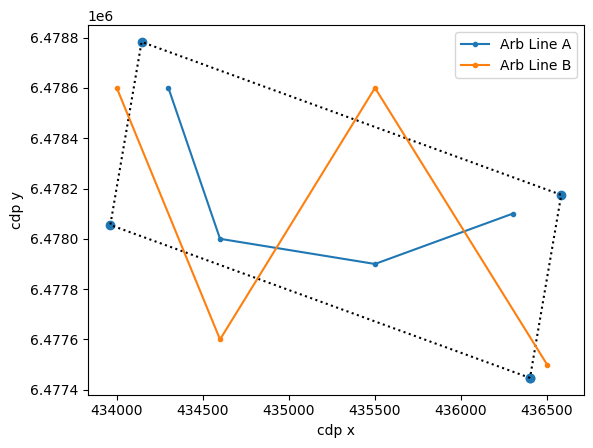

In [7]:
ax = volve_3d.segysak.plot_bounds()
ax.plot(arb_line_A[:, 0], arb_line_A[:, 1], ".-", label="Arb Line A")
ax.plot(arb_line_B[:, 0], arb_line_B[:, 1], ".-", label="Arb Line B")
ax.legend()

Let's extract line A.

We specify a `bin_spacing_hint` which is our desired bin spacing along the line. The function use this hint to calculate the closest binspacing that maintains uniform sampling.

We have also specified the `method='linear'`, this is the default but you can specify and method that `DataArray.interp` accepts

In [8]:
from time import time

tic = time()
line_A = volve_3d.segysak.interp_line(arb_line_A, bin_spacing_hint=10)
toc = time()
print(f"That took {toc-tic} seconds")

That took 0.15014243125915527 seconds


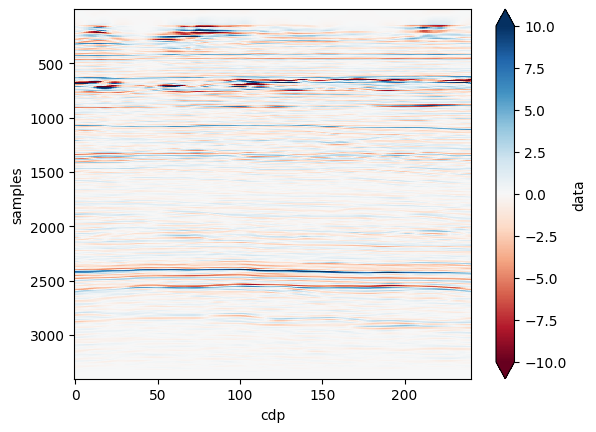

In [9]:
line_A.data.T.plot(yincrease=False, cmap="RdBu", vmin=-10, vmax=10)

Now, let's extract line B. Note that blank traces are inserted where the line extends outside the survey bounds.

In [10]:
tic = time()
line_B = volve_3d.segysak.interp_line(arb_line_B, bin_spacing_hint=10)
toc = time()
print(f"That took {toc-tic} seconds")

That took 0.12073421478271484 seconds


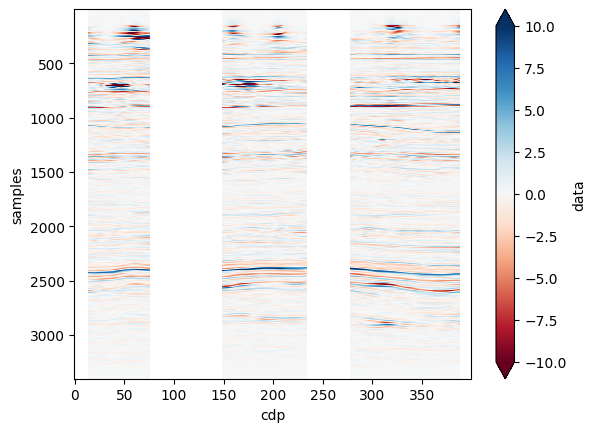

In [11]:
line_B.data.T.plot(yincrease=False, cmap="RdBu", vmin=-10, vmax=10)

## Petrel Shapefile

We have an arbitrary line geometry defined over this small survey region stored in a shape file exported from Petrel.

Let's load that and extract an arbitrary line using segysak. We also have the seismic data extracted along that line by Petrel, so we can see how that compares.

In [12]:
import shapefile
from pprint import pprint

Load the shapefile and get the list of points from the first shape object `sf.shape(0)`.

In [13]:
sf = shapefile.Reader(pathlib.Path("data/arbitrary_line.shp"))

# see the shapes in the file -> there is just one `Shape #0`
print(sf.shapes())

# get the first shape
petrel_line = sf.shape(0)
petrel_line_points = np.asarray(petrel_line.points)

Shapes: [Shape #0: POLYLINEZ]


Load the segy containing the line that Petrel extracted along this geometry

In [14]:
line_extracted_by_petrel_path = pathlib.Path("data/volve10r12-full-twt-arb.sgy")
print(
    f"{line_extracted_by_petrel_path} exists: {line_extracted_by_petrel_path.exists()}"
)
line_extracted_by_petrel = xr.open_dataset(
    line_extracted_by_petrel_path,
    dim_byte_fields={"cdp":21,},
    extra_byte_fields={"cdp_x":73, "cdp_y":77} 
)

data/volve10r12-full-twt-arb.sgy exists: True


Extract the line using segysak

In [15]:
tic = time()
line_extracted_by_segysak = volve_3d.segysak.interp_line(
    petrel_line.points,
    bin_spacing_hint=10,
    line_method="linear",
    xysel_method="linear",
)
line_extracted_by_petrel.segysak.scale_coords()
toc = time()
print(f"That took {toc-tic} seconds")

That took 0.0757911205291748 seconds


Plot the extracted lines side by side

Text(0.5, 1.0, 'petrel')

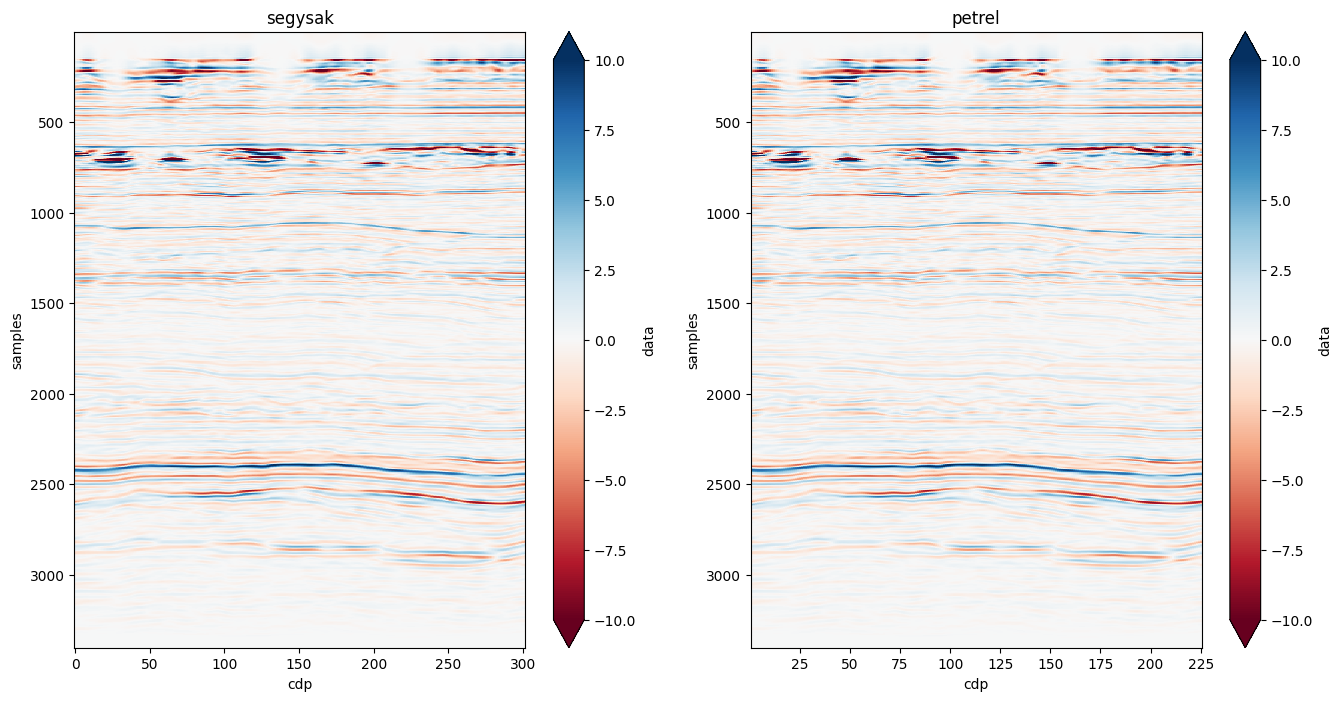

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

line_extracted_by_segysak.data.T.plot(yincrease=False, vmin=-10, vmax=10, cmap='RdBu', ax=axs[0])
axs[0].set_title("segysak")

line_extracted_by_petrel.data.T.plot(yincrease=False, vmin=-10, vmax=10, cmap='RdBu', ax=axs[1])
axs[1].set_title("petrel")

Plot the geometry, trace header locations along with the volve 3d bound box, to make sure things line up.

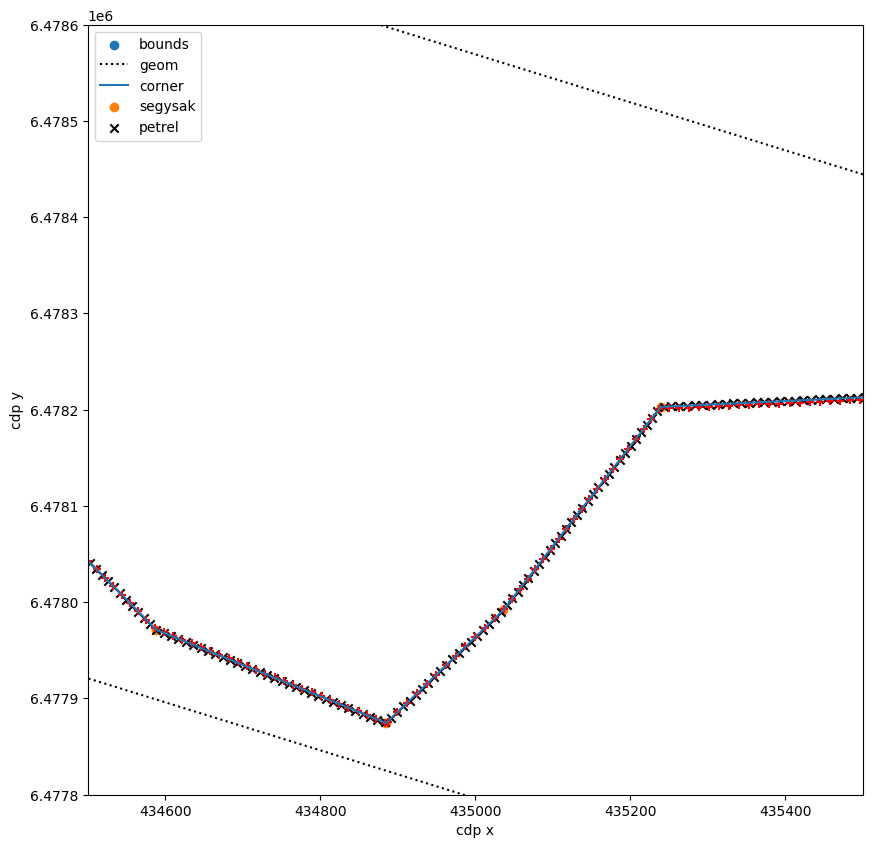

In [17]:
plt.figure(figsize=(10, 10))
ax = volve_3d.segysak.plot_bounds(ax=plt.gca())

# plot path
ax.plot(petrel_line_points[:, 0], petrel_line_points[:, 1])
ax.scatter(petrel_line_points[:, 0], petrel_line_points[:, 1])

# plot trace positons from extracted lines based on header
ax.scatter(
    line_extracted_by_segysak.cdp_x,
    line_extracted_by_segysak.cdp_y,
    marker="x",
    color="k",
)
ax.scatter(
    line_extracted_by_petrel.cdp_x,
    line_extracted_by_petrel.cdp_y,
    marker="+",
    color="r",
)

ax.set_xlim(434500, 435500)
ax.set_ylim(6477800, 6478600)
plt.legend(labels=["bounds", "geom", "corner", "segysak", "petrel"])

## Well Paths

Well paths can also be treated as an arbitrary line. In this example we will use the Affine transform to convert well X and Y locations to the seismic local grid, and the Xarray `interp` method to extract a seismic trace along the well bore.

First we have to load the well bore deviation and use `wellpathpy` to convert it to XYZ coordinates with a higher sampling rate.

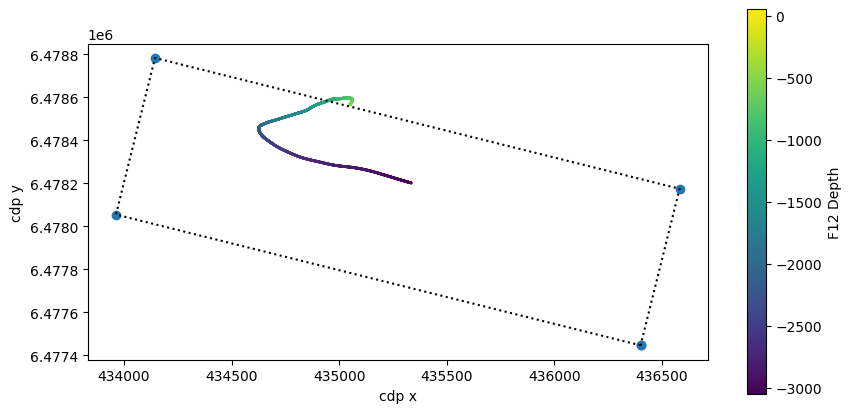

In [18]:
f12_dev = pd.read_csv("data/well_f12_deviation.asc", comment="#", sep='\s+')
f12_dev_pos = wpp.deviation(*f12_dev[["MD", "INCL", "AZIM_GN"]].values.T)

# depth values in MD that we want to sample the seismic cube at
new_depths = np.arange(0, f12_dev["MD"].max(), 1)

# use minimum curvature and resample to 1m interval
f12_dev_pos = f12_dev_pos.minimum_curvature().resample(new_depths)

# adjust position of deviation to local coordinates and TVDSS
f12_dev_pos.to_wellhead(
    6478566.23,
    435050.21,
    inplace=True,
)
f12_dev_pos.to_tvdss(
    54.9,
    inplace=True,
)

fig, ax = plt.subplots(figsize=(10, 5))
volve_3d.segysak.plot_bounds(ax=ax)
sc = ax.scatter(f12_dev_pos.easting, f12_dev_pos.northing, c=f12_dev_pos.depth, s=1)
plt.colorbar(sc, label="F12 Depth")
ax.set_aspect("equal")

We can easily sample the seismic cube by converting the positional log to `iline` and `xline` using the Affine transform for our data. We also need to convert the TVDSS values of the data to TWT (in this case we will just use a constant velocity).

In both instances we will create custom xarray.DataArray instances because this allows us to relate the coordinate systems of well samples (on the new dimension `well`) to the `iline` and `xline` dimensions of the cube.

In [19]:
# need the inverse to go from xy to il/xl
affine = volve_3d.segysak.get_affine_transform().inverted()
ilxl = affine.transform(np.dstack([f12_dev_pos.easting, f12_dev_pos.northing])[0])

f12_dev_ilxl = dict(
    iline=xr.DataArray(ilxl[:, 0], dims="well", coords={"well": range(ilxl.shape[0])}),
    xline=xr.DataArray(ilxl[:, 1], dims="well", coords={"well": range(ilxl.shape[0])}),
)

twt = xr.DataArray(
    -1.0 * f12_dev_pos.depth * 2000 / 2400,  # 2400 m/s to convert to TWT - and negate,
    dims="well",
    coords={"well": range(ilxl.shape[0])},
)

f12_dev_ilxl

{'iline': <xarray.DataArray (well: 3520)> Size: 28kB
 array([10150.73832115, 10150.73832115, 10150.73832115, ...,
        10127.96024075, 10127.95847287, 10127.95670499])
 Coordinates:
   * well     (well) int64 28kB 0 1 2 3 4 5 6 ... 3514 3515 3516 3517 3518 3519,
 'xline': <xarray.DataArray (well: 3520)> Size: 28kB
 array([2276.47797909, 2276.47797909, 2276.47797909, ..., 2247.46429975,
        2247.40054283, 2247.33678592])
 Coordinates:
   * well     (well) int64 28kB 0 1 2 3 4 5 6 ... 3514 3515 3516 3517 3518 3519}

The DataArrays with the new axes can be passed to interp which will perform interpolation for us on the new dimension `well`.

We can also plot the well path on our seismic extracted along the well path.

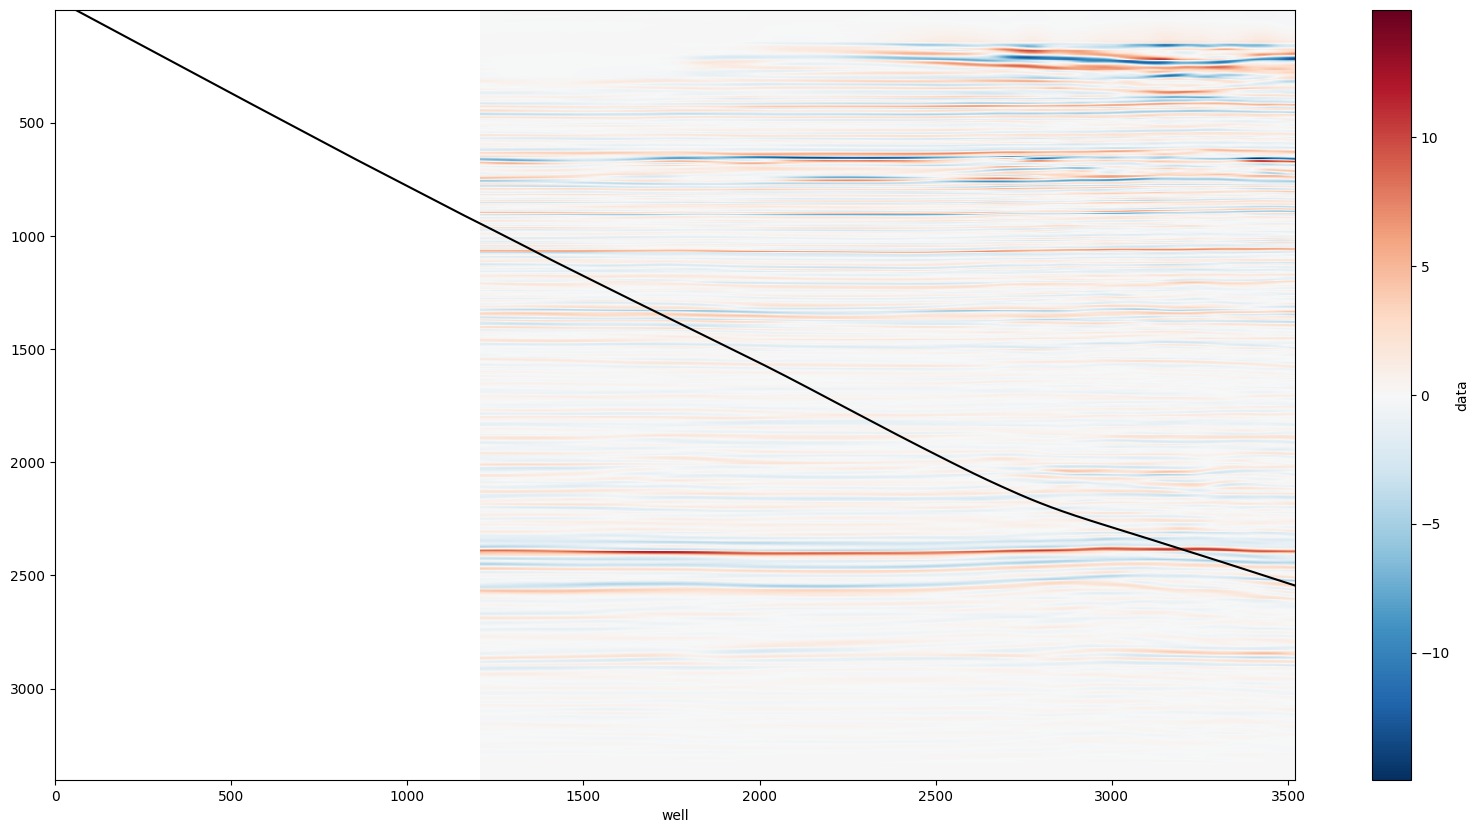

In [20]:
sel = volve_3d.interp(**f12_dev_ilxl)
fig, axs = plt.subplots(figsize=(20, 10))
sel.data.T.plot(ax=axs, yincrease=False)
twt.plot(color="k", ax=axs)

To extract the data along the well path we just need to interpolate using the additional `twt` DataArray.

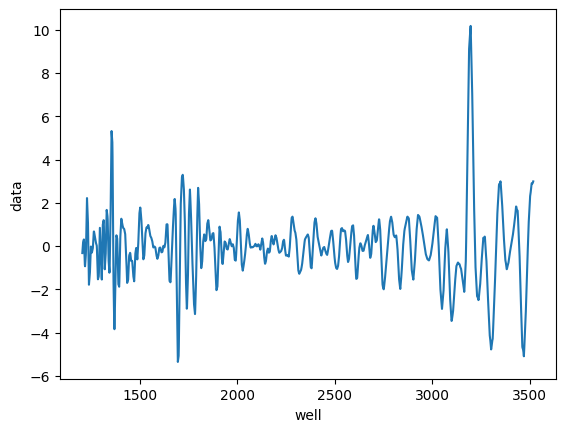

In [21]:
well_seismic = volve_3d.interp(**f12_dev_ilxl, samples=twt)
well_seismic.data.plot()